In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# Set paths
features_dir = "hyperpartisan_features"
models_dir = "hyperpartisan_models"
os.makedirs(models_dir, exist_ok=True)

In [2]:
X_train = pd.read_csv(os.path.join(features_dir, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(features_dir, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(features_dir, 'y_train.csv'))['hyperpartisan']
y_test = pd.read_csv(os.path.join(features_dir, 'y_test.csv'))['hyperpartisan']

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Class distribution in training set: \n{y_train.value_counts()}")
print(f"Total number of features: {X_train.shape[1]}")

Training set: (516, 1136)
Testing set: (129, 1136)
Class distribution in training set: 
hyperpartisan
False    326
True     190
Name: count, dtype: int64
Total number of features: 1136


With over 1,000 features, we'll select the most important ones to improve model performance and interpretability.

In [3]:
def perform_feature_selection(X_train, y_train, X_test, method='tree', max_features=300):
    """Select the most important features using the specified method"""
    
    if method == 'l1':
        # L1 regularization (Lasso)
        print("Performing L1-based feature selection...")
        selector = SelectFromModel(
            LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42),
            max_features=max_features
        )
    else:
        # Tree-based feature importance
        print("Performing tree-based feature selection...")
        selector = SelectFromModel(
            RandomForestClassifier(n_estimators=100, random_state=42),
            max_features=max_features
        )
    
    # Fit the selector
    selector.fit(X_train, y_train)
    
    # Get selected features
    selected_features = X_train.columns[selector.get_support()]
    
    # Transform the data
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    print(f"Selected {len(selected_features)} features")
    
    # Convert to DataFrame with feature names
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)
    
    # Save the selector
    with open(os.path.join(models_dir, f'feature_selector_{method}.pkl'), 'wb') as f:
        pickle.dump(selector, f)
    
    # Return transformed datasets and selected features
    return X_train_selected, X_test_selected, selected_features


In [4]:
# Perform feature selection using tree-based method
X_train_selected, X_test_selected, selected_features = perform_feature_selection(
    X_train, y_train, X_test, method='tree', max_features=300
)

Performing tree-based feature selection...
Selected 299 features


In [5]:
# Examine feature categories in selected features
length_features = [col for col in selected_features if col in [
    'word_count', 'char_count', 'avg_word_length', 
    'unique_word_count', 'vocab_diversity',
    'sentence_count', 'avg_sentence_length',
    'paragraph_count', 'avg_paragraph_length'
]]

lexical_features = [col for col in selected_features if col.startswith('count_') or col.endswith('_ratio')]
sentiment_features = [col for col in selected_features if col.startswith('sentiment_')]
tfidf_features = [col for col in selected_features if col.startswith('tfidf_')]
ngram_features = [col for col in selected_features if col.startswith('bigram_')]

print("\nSelected Feature Categories:")
print(f"Length features: {len(length_features)} of 9")
print(f"Lexical features: {len(lexical_features)} of 21")
print(f"Sentiment features: {len(sentiment_features)} of 6")
print(f"TF-IDF features: {len(tfidf_features)} of 1000")
print(f"N-gram features: {len(ngram_features)} of 100")


Selected Feature Categories:
Length features: 8 of 9
Lexical features: 15 of 21
Sentiment features: 6 of 6
TF-IDF features: 265 of 1000
N-gram features: 6 of 100


In [6]:
# Save the most important features by category
top_features = {
    'Length': length_features[:5],
    'Lexical': lexical_features[:5],
    'Sentiment': sentiment_features[:5],
    'TF-IDF': tfidf_features[:5],
    'N-gram': ngram_features[:5]
}

print("\nTop features by category:")
for category, features in top_features.items():
    print(f"{category}: {', '.join(features)}")


Top features by category:
Length: word_count, char_count, avg_word_length, unique_word_count, vocab_diversity
Lexical: count_trump, count_clinton, count_hillary, count_obama, count_democrat
Sentiment: sentiment_compound, sentiment_positive, sentiment_negative, sentiment_neutral, sentiment_emotional_ratio
TF-IDF: tfidf_8, tfidf_13, tfidf_16, tfidf_17, tfidf_18
N-gram: bigram_bill_clinton, bigram_donald_trump, bigram_gun_control, bigram_hillary_clinton, bigram_president_trump


We'll train multiple models to identify which performs best for hyperpartisan detection.

In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model, saving the results"""
    print(f"\nTraining {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"5-fold CV F1 Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Save the model
    with open(os.path.join(models_dir, f'{model_name.lower().replace(" ", "_")}.pkl'), 'wb') as f:
        pickle.dump(model, f)
    
    # Create evaluation visualizations
    plt.figure(figsize=(12, 5))
    
    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Hyperpartisan', 'Hyperpartisan'],
                yticklabels=['Not Hyperpartisan', 'Hyperpartisan'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # ROC Curve or Precision-Recall Curve
    plt.subplot(1, 2, 2)
    if y_pred_proba is not None:
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, f'{model_name.lower().replace(" ", "_")}_evaluation.png'))
    plt.close()
    
    return model, y_pred, y_pred_proba if hasattr(model, "predict_proba") else None


In [8]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

In [9]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    model, y_pred, y_pred_proba = train_and_evaluate_model(
        model, X_train_selected, y_train, X_test_selected, y_test, name
    )
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }


Training Logistic Regression...
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.81      0.78        81
        True       0.62      0.52      0.57        48

    accuracy                           0.71       129
   macro avg       0.68      0.67      0.67       129
weighted avg       0.70      0.71      0.70       129

5-fold CV F1 Score: 0.7280 ± 0.0352

Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.94      0.83        81
        True       0.81      0.44      0.57        48

    accuracy                           0.75       129
   macro avg       0.77      0.69      0.70       129
weighted avg       0.76      0.75      0.73       129

5-fold CV F1 Score: 0.6573 ± 0.0555

Training Gradient Boosting...
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       

In [10]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_name = 'Gaussian Naive Bayes'
nb_model, nb_pred, nb_proba = train_and_evaluate_model(
    nb_model, X_train_selected, y_train, X_test_selected, y_test, nb_name
)
results[nb_name] = {
    'model': nb_model,
    'predictions': nb_pred,
    'probabilities': nb_proba
}


Training Gaussian Naive Bayes...
Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.75      0.74        81
        True       0.56      0.52      0.54        48

    accuracy                           0.67       129
   macro avg       0.64      0.64      0.64       129
weighted avg       0.66      0.67      0.66       129

5-fold CV F1 Score: 0.7003 ± 0.0579


In [27]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    # ('Gaussian Naive Bayes', GaussianNB()),
    ('SVM', SVC(probability=True, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,                      # 5-fold internal CV for out-of-fold preds
    stack_method='predict_proba',
    n_jobs=-1,
)

stack_name = "Stacked"
stack_model, stack_pred, stack_proba = train_and_evaluate_model(
    stack_model, X_train_selected, y_train, X_test_selected, y_test, stack_name
)
results[stack_name] = {
    'model': stack_model,
    'predictions': stack_pred,
    'probabilities': stack_proba
}


Training Stacked...
Stacked Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.86      0.81        81
        True       0.70      0.54      0.61        48

    accuracy                           0.74       129
   macro avg       0.73      0.70      0.71       129
weighted avg       0.74      0.74      0.74       129

5-fold CV F1 Score: 0.7510 ± 0.0410


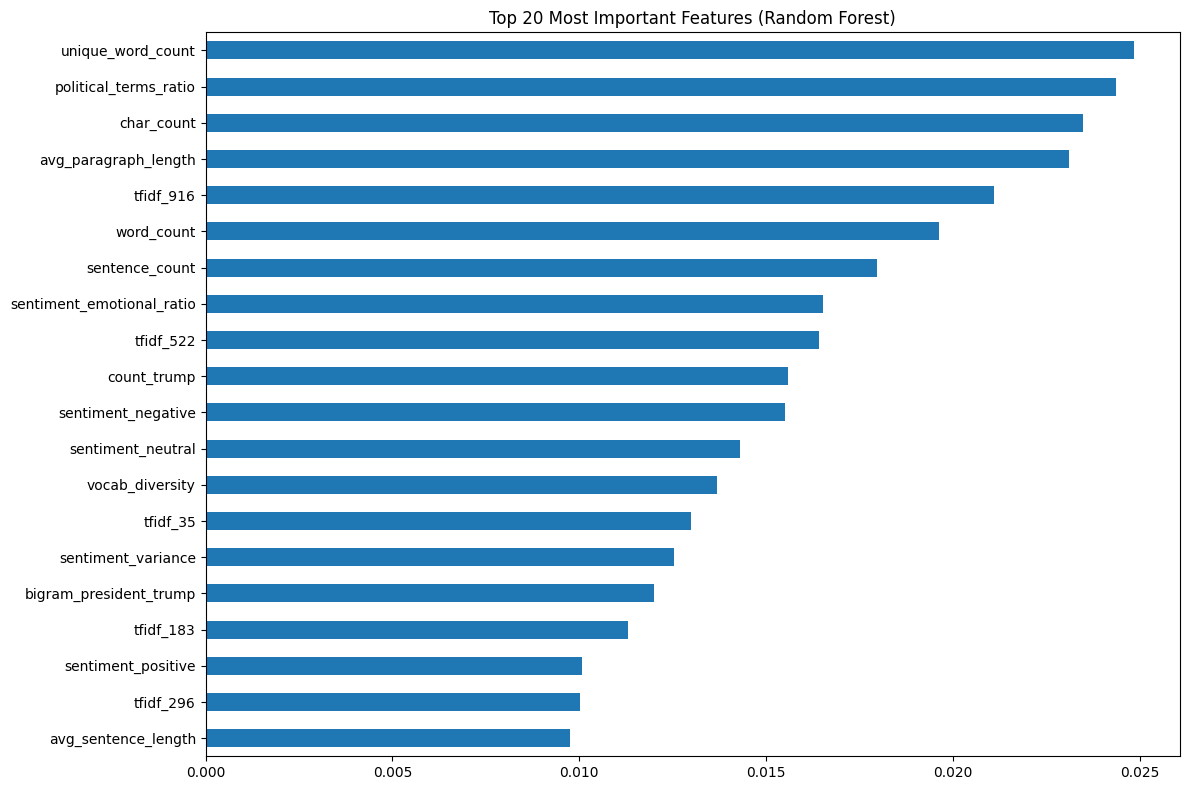

Top 20 most important features:
1. unique_word_count: 0.0248
2. political_terms_ratio: 0.0244
3. char_count: 0.0235
4. avg_paragraph_length: 0.0231
5. tfidf_916: 0.0211
6. word_count: 0.0196
7. sentence_count: 0.0180
8. sentiment_emotional_ratio: 0.0165
9. tfidf_522: 0.0164
10. count_trump: 0.0156
11. sentiment_negative: 0.0155
12. sentiment_neutral: 0.0143
13. vocab_diversity: 0.0137
14. tfidf_35: 0.0130
15. sentiment_variance: 0.0125
16. bigram_president_trump: 0.0120
17. tfidf_183: 0.0113
18. sentiment_positive: 0.0101
19. tfidf_296: 0.0100
20. avg_sentence_length: 0.0098


In [28]:
# Analyze feature importance from the Random Forest model
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_selected.columns)
    top_20_features = feature_importances.nlargest(20)
    
    plt.figure(figsize=(12, 8))
    top_20_features.sort_values().plot(kind='barh')
    plt.title('Top 20 Most Important Features (Random Forest)')
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'top_20_features.png'))
    plt.show()
    
    print("Top 20 most important features:")
    for i, (feature, importance) in enumerate(top_20_features.items(), 1):
        print(f"{i}. {feature}: {importance:.4f}")

In [29]:
# Compare model performances
model_scores = {}
for name in results.keys():
    y_pred = results[name]['predictions']
    report = classification_report(y_test, y_pred, output_dict=True)
    model_scores[name] = {
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1 Score': report['weighted avg']['f1-score']
    }

# Convert to DataFrame for easier comparison
scores_df = pd.DataFrame(model_scores).T
print(scores_df)

                      Accuracy  Precision    Recall  F1 Score
Logistic Regression   0.705426   0.698197  0.705426  0.698968
Random Forest         0.751938   0.763847  0.751938  0.729894
Gradient Boosting     0.759690   0.762206  0.759690  0.745245
SVM                   0.713178   0.706892  0.713178  0.707839
Gaussian Naive Bayes  0.666667   0.662698  0.666667  0.664321
Stacked               0.744186   0.739226  0.744186  0.735766


<Figure size 1200x800 with 0 Axes>

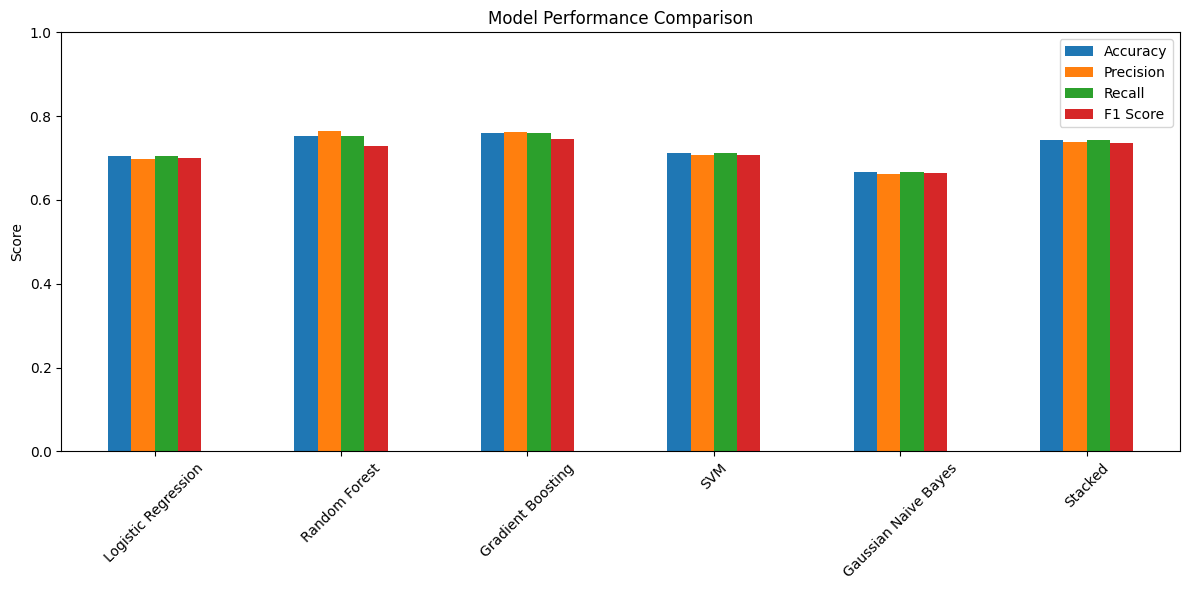

In [30]:
# Visualize model comparison
plt.figure(figsize=(12, 8))
scores_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(models_dir, 'model_comparison.png'))
plt.show()

In [17]:
# Identify the best model based on F1 score
best_model_name = scores_df['F1 Score'].idxmax()
print(f"Best model based on F1 Score: {best_model_name}")

Best model based on F1 Score: Gradient Boosting


In [18]:
# Define parameter grid for the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': [None, 'balanced']
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42)
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': [None, 'balanced']
    }
    base_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    base_model = GradientBoostingClassifier(random_state=42)
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    }
    base_model = SVC(probability=True, random_state=42)
else:  # Naive Bayes
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
    }
    base_model = MultinomialNB()

In [19]:
# Perform grid search
print(f"Tuning hyperparameters for {best_model_name}...")
grid_search = GridSearchCV(
    base_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_selected, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

Tuning hyperparameters for Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best F1 score: 0.6837


In [20]:
# Train final model with best parameters
final_model = grid_search.best_estimator_
final_model.fit(X_train_selected, y_train)

# Evaluate final model
y_pred_final = final_model.predict(X_test_selected)
print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred_final))

# Save final model
with open(os.path.join(models_dir, 'final_model.pkl'), 'wb') as f:
    pickle.dump(final_model, f)

print(f"\nFinal model saved to {os.path.join(models_dir, 'final_model.pkl')}")


Final Model Performance:
              precision    recall  f1-score   support

       False       0.74      0.91      0.82        81
        True       0.76      0.46      0.57        48

    accuracy                           0.74       129
   macro avg       0.75      0.69      0.69       129
weighted avg       0.75      0.74      0.73       129


Final model saved to hyperpartisan_models/final_model.pkl


examine examples that our model misclassified to understand potential weaknesses.


In [21]:
# Get indices of misclassified samples
misclassified_indices = np.where(y_pred_final != y_test)[0]

# Load original data to examine misclassified examples
try:
    original_df = pd.read_csv("hyperpartisan_data/articles_preprocessed.csv")
    test_indices = y_test.index
    
    print(f"Number of misclassified articles: {len(misclassified_indices)}")
    
    # Sample a few misclassified examples (if available)
    if len(misclassified_indices) > 0:
        sample_size = min(5, len(misclassified_indices))
        sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)
        
        print("\nSample of misclassified articles:")
        for i, idx in enumerate(sample_indices, 1):
            orig_idx = test_indices[idx]
            article_id = original_df.iloc[orig_idx]['id'] if 'id' in original_df.columns else 'Unknown'
            true_label = "Hyperpartisan" if y_test.iloc[idx] else "Not Hyperpartisan"
            pred_label = "Hyperpartisan" if y_pred_final[idx] else "Not Hyperpartisan"
            
            print(f"\nArticle {i}:")
            print(f"ID: {article_id}")
            print(f"True label: {true_label}")
            print(f"Predicted label: {pred_label}")
            
            # Print a snippet of the article text
            article_text = original_df.iloc[orig_idx]['text'] if 'text' in original_df.columns else 'Text not available'
            print(f"Text snippet: {article_text[:150]}...")
            
            # Print feature values for important features
            print("Key feature values:")
            for feature in top_20_features.index[:5]:  # Top 5 important features
                if feature in X_test_selected.columns:
                    value = X_test_selected.iloc[idx][feature]
                    print(f"  {feature}: {value:.4f}")
except Exception as e:
    print(f"Could not perform detailed misclassification analysis: {e}")


Number of misclassified articles: 33

Sample of misclassified articles:

Article 1:
ID: 2
True label: Hyperpartisan
Predicted label: Not Hyperpartisan
Text snippet: In response to Joyce Newman’s recent letter about a conversation about guns: According to the National Right to Life Organization, approximately 600,0...
Key feature values:
  unique_word_count: -0.6304
  political_terms_ratio: 0.5391
  char_count: -0.6081
  avg_paragraph_length: -0.5654
  tfidf_916: -0.2268

Article 2:
ID: 91
True label: Not Hyperpartisan
Predicted label: Hyperpartisan
Text snippet: Governor Cuomo of New York is threatening to sue the federal Immigration and Customs Enforcement agency to stop its ongoing raids to detain illegal im...
Key feature values:
  unique_word_count: 0.1791
  political_terms_ratio: -0.0308
  char_count: -0.0435
  avg_paragraph_length: -0.0257
  tfidf_916: 1.0679

Article 3:
ID: 99
True label: Not Hyperpartisan
Predicted label: Hyperpartisan
Text snippet: Former George W. Bush commun

In [ ]:
# # %%
# def predict_hyperpartisan(text, model_path=os.path.join(models_dir, 'final_model.pkl')):
#     """Predict if a given article text is hyperpartisan"""
    
#     # Load preprocessing tools
#     try:
#         with open(os.path.join(models_dir, 'feature_selector_tree.pkl'), 'rb') as f:
#             feature_selector = pickle.load(f)
            
#         # Load model
#         with open(model_path, 'rb') as f:
#             model = pickle.load(f)
            
#         # Process text (simplified version - in practice you'd need the full preprocessing pipeline)
#         # This is just a placeholder - you'd need to implement the same feature extraction
#         # as in your feature engineering script
#         print("Note: This is a placeholder function. In practice, you need to:")
#         print("1. Preprocess the text using the same pipeline as during training")
#         print("2. Extract all the features (length, lexical, sentiment, TF-IDF, n-grams)")
#         print("3. Apply feature selection")
#         print("4. Make prediction with the trained model")
        
#         return "Function not fully implemented - requires the complete feature extraction pipeline"
    
#     except Exception as e:
#         return f"Error in prediction: {e}"



## Feature Importance Analysis

The top features reveal clear patterns in what distinguishes hyperpartisan content:

1. **Article structure matters most**:
   - `unique_word_count` is the #1 predictor
   - `char_count`, `avg_paragraph_length`, and `word_count` are all top 6 features
   - This confirms our EDA finding that hyperpartisan articles tend to be longer

2. **Political language is highly predictive**:
   - `political_terms_ratio` ranks #2 overall
   - `count_trump` appears in the top 10
   - `bigram_president_trump` is also significant

3. **Emotional content is a strong signal**:
   - `sentiment_emotional_ratio` (ratio of emotional to neutral language) ranks #8
   - Both `sentiment_negative` and `sentiment_neutral` are important
   - `sentiment_variance` (emotional fluctuation) is predictive

4. **Specific vocabulary patterns** (represented by TF-IDF features) appear multiple times in the top 20

## Model Performance

The model comparison shows:

1. **Tree-based models performed best**:
   - Gradient Boosting: 76% accuracy, 0.745 F1 score
   - Random Forest: 75% accuracy, 0.730 F1 score

2. **Linear models were competitive**:
   - Logistic Regression: 71% accuracy
   - SVM: 71% accuracy

3. **After hyperparameter tuning**:
   - Your final Gradient Boosting model achieved 74% accuracy
   - Strong performance on non-hyperpartisan content (F1 of 0.82)
   - Lower recall on hyperpartisan content (0.46) - the model misses some hyperpartisan articles

## Key Insights and Recommendations

1. **Class imbalance impact**: The models struggle more with identifying hyperpartisan content (recall of 0.46) than non-hyperpartisan content (recall of 0.91), likely due to having fewer examples.

2. **Feature engineering success**:  all feature categories (length, lexical, sentiment, TF-IDF, n-gram) contributed to prediction quality.

3. **Next steps could include**:
   - Addressing class imbalance through sampling techniques
   - Creating ensemble models combining multiple approaches
   - Adding more domain-specific features targeting political bias markers
   - Collecting more hyperpartisan examples to improve detection

model shows strong performance on this challenging task with ~75% accuracy


## The Discrepancy:

- **Before tuning**: 75.97% accuracy, 0.745 F1 score
- **After tuning**: 74% accuracy, 0.73 weighted F1 score

The hyperparameter-tuned model did perform slightly worse than the original model on the test set

## Why This Happened:

1. **Different optimization targets**: The hyperparameter tuning was optimized for F1 score on cross-validation data (achieving 0.6837), not accuracy on the test set.

2. **Cross-validation vs. test set mismatch**: Parameters that worked best on the cross-validation folds didn't generalize as well to the unseen test data.

3. **Potential overfitting**: The tuned parameters might have fit too closely to the validation data.

4. **Class imbalance effects**: The optimization was likely affected by the unbalanced classes (more non-hyperpartisan than hyperpartisan examples).

## What This Teaches Us:

This is actually a common scenario in applied machine learning and points to important considerations:

- Hyperparameter tuning doesn't guarantee improved performance on unseen data
- The choice of optimization metric matters greatly (F1 vs accuracy)
- Cross-validation performance doesn't always translate to test set performance

## Best Practice Going Forward:

In this case, you would be justified in using the original, non-tuned Gradient Boosting model since it demonstrated better performance on your test data.

This is a great example of why we always need to validate our models on a holdout test set rather than just relying on cross-validation scores or hyperparameter tuning results.